---
# MATH 434/534 Case Study: Image Deblurring
---

<img src="jetplane.tif" width=384> | <img src="jetplaneblurred.tif" width=384>
:----------------:|:------------------------:
Original image    | Blurred image


Images captured by cameras are often blurry; for example, the lens may not be focused, or the cameraman’s hand could be shaky. One important problem in [digital image processing](https://en.wikipedia.org/wiki/Digital_image_processing) is thus to _deblur_ an image. A simple idea is to model the blurred image as an output of a linear map (i.e., multiplication by a matrix) on the original image. Under that assumption, the process of deblurring essentially involves solving a system of linear equations.

## Images as matrices

For simplicity, we will only consider greyscale images. Such an image can be regarded as a two-dimensional array, where each entry corresponds to the intensity of a pixel in the image. Typical values for intensity are integers from 0 to 255, with 0 meaning black and 255 meaning white. Dividing by 255, these 256 different integer values can be scaled to be between 0 and 1.  See the JuliaImages documentation on the [0-to-1 intensity scale](https://juliaimages.org/latest/quickstart/#The-0-to-1-intensity-scale-1).

---
### Exercise 1

1. Install and load the `Julia` package [`Images`](https://github.com/JuliaImages/Images.jl).
2. Load the `cameraman.tif` image into a variable called `img`. What is `size(img)`?
3. Convert `img` to a two-dimensional array of `Float64` values between 0 and 1 called `Xtrue`. Verify that the entries of `255*Xtrue` are indeed integers between 0 and 255.
4. Convert `Xtrue` back to an image using the `Gray` function.

In [211]:
using Images, ImageMagick

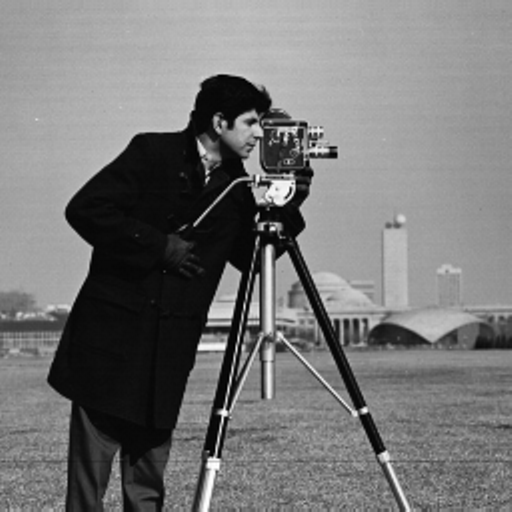

In [212]:
img = load("cameraman.tif")

In [213]:
println("Size of image is: ", size(img))

Size of image is: (512, 512)


In [214]:
Xtrue = convert(Array{Float64}, img)

512×512 Array{Float64,2}:
 0.611765  0.615686  0.627451  0.623529  …  0.596078  0.596078  0.596078
 0.611765  0.615686  0.623529  0.619608     0.596078  0.596078  0.596078
 0.619608  0.615686  0.611765  0.611765     0.596078  0.596078  0.596078
 0.627451  0.615686  0.603922  0.603922     0.6       0.596078  0.596078
 0.619608  0.615686  0.611765  0.611765     0.6       0.596078  0.596078
 0.611765  0.615686  0.623529  0.623529  …  0.6       0.6       0.6     
 0.619608  0.615686  0.611765  0.611765     0.6       0.6       0.6     
 0.627451  0.615686  0.603922  0.603922     0.6       0.6       0.6     
 0.619608  0.607843  0.6       0.6          0.596078  0.596078  0.596078
 0.611765  0.603922  0.6       0.6          0.592157  0.596078  0.596078
 0.607843  0.603922  0.603922  0.6       …  0.588235  0.596078  0.596078
 0.607843  0.607843  0.607843  0.603922     0.592157  0.596078  0.596078
 0.607843  0.603922  0.6       0.6          0.592157  0.588235  0.588235
 ⋮                       

In [215]:
#= This function will check all elements in the array and return true if all
elements return true for the condition =#
all(i->(0<=i<=255), 255*Xtrue)

true

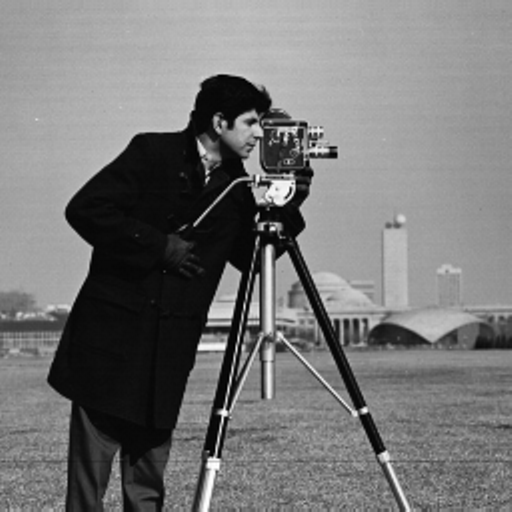

In [216]:
Gray.(Xtrue)

---

## The blurring process

Let $X_\mathrm{true} \in \mathbb{R}^{m \times n}$  denote the true image and $Y \in \mathbb{R}^{m \times n}$ denote the blurred image. We assume the blurring process is described by 

$$
Y = A_c X_\mathrm{true} A_r^T + \varepsilon
$$

for some blurring matrices $A_c \in \mathbb{R}^{m \times m}$ and $A_r \in \mathbb{R}^{n \times n}$, and a matrix $\varepsilon$ that captures measurement errors. We will assume that each entry $\varepsilon_{ij}$ of the matrix $\varepsilon$ is [normally distributed](https://en.wikipedia.org/wiki/Normal_distribution) with mean 0 and variance $\tau^2$, for some $\tau > 0$, which can be written as $\varepsilon_{ij} \sim \mathcal{N}(0, \tau^2)$.

---
### Exercise 2

1. The **probability density function** of the normal distribution $\mathcal{N}(\mu, \sigma^2)$ with mean $\mu$ and variance $\sigma^2$ is defined as

   $$f(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right).$$

   Write a `Julia` function `f(x; μ=0.0, σ=1.0)` having named parameters `μ` and `σ` with default values `0.0` and `1.0`, respectively.

2. Install and load the `Julia` package [`Plots`](https://github.com/JuliaPlots/Plots.jl).

3. Use your `Julia` function `f` to plot $f(x)$ using various choices of $\mu$ and $\sigma$.

In [217]:
function f(x; μ=0.0, σ=1.0)
    return (1/sqrt(2*π*σ^2))*exp(-(x-μ)^2/(2*σ^2))
end

f (generic function with 1 method)

In [218]:
f1(x) = f(x,μ=0.1,σ=1.1)
f2(x) = f(x,μ=0.5,σ=1.5)
f3(x) = f(x,μ=1,σ=2)

f3 (generic function with 1 method)

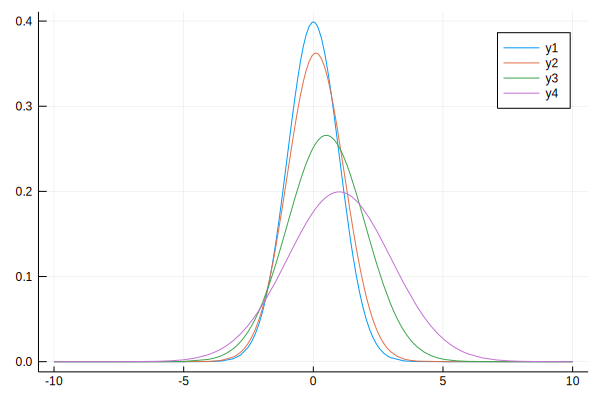

In [219]:
using Plots

plot(f, -10, 10)
plot!(f1, -10, 10)
plot!(f2, -10, 10)
plot!(f3, -10, 10)

---

## The blurring matrices $A_c$ and $A_r$

To understand the action of the blurring matrices, imagine you are taking a picture of a point source, i.e., a picture $X_0$ that is nonzero only at entry $(i,j)$ and zero everywhere else. Then $A_cX_0$ can only have nonzero entries along the $j$th column. Thus, the matrix $A_c$ describes how blurring occurs in the vertical direction. Similarly, $A_r$ describes how blurring occurs in the horizontal direction, and we see that $X_0A_r^T$ can only have nonzero entries along the $i$th row.

The $j$th column of a matrix can be extracted by multiplication on the right by the vector $e_j$, which has a single 1 at the $j$th entry, and is zero otherwise. The $j$th column of the matrix $A_c$ describes the blurring effect on a "light source" at the $j$th position. [Gaussian blurring](https://en.wikipedia.org/wiki/Gaussian_blur) redistributes the single light source according to a Gaussian distribution. Thus, the $(i,j)$ entry of $A_c$ is given by

$$
(A_c)_{ij} = (A_c e_j)_i = f(i - j) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(i - j)^2}{2\sigma^2}\right),
$$

where $f(x)$ is the probability density function of $\mathcal{N}(0, \sigma^2)$. 

Similarly, the $i$th row of a matrix can be extracted by multiplication on the left by the vector $e_i^T$, which has a single 1 at the $i$th entry, and is zero otherwise. Thus, the $(i,j)$ entry of $A_r^T$ is also given by

$$
(A_r^T)_{ij} = (e_i^T A_r^T)_j = f(i - j) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(i - j)^2}{2\sigma^2}\right).
$$

Notice that both $A_r$ and $A_c$ are symmetric since $f(i - j) = f(j - i)$. Thus, $(A_r)_{ij} = f(i - j)$ as well.

---
### Exercise 3

1. Write a function `blurmatrix(n, σ)` that returns an $n \times n$ blurring matrix $A$, defined by $A_{ij} = f(i-j)$. Use your `f` function from Exercise 2 and [array comprehensions](https://docs.julialang.org/en/v1/manual/arrays/#Comprehensions-1) to code this function in one line: `blurmatrix(n, σ) = ...`.

2. Using $\sigma = 4$, create the matrices $A_c$ and $A_r$. Display the three images $A_c X_\mathrm{true}$, $X_\mathrm{true} A_r^T$, and $A_c X_\mathrm{true} A_r^T$. What do you observe?

3. Write a function `blur(X, Ac, Ar, τ)` that returns the noisy blurred image $Y = A_cXA_r^T + \varepsilon$, where $\varepsilon_{ij} \sim \mathcal{N}(0, \tau^2)$. In `Julia`, the $\varepsilon$ matrix can be computed by `ε = τ*randn(m, n)`. Use the function `clamp01` to ensure $0 \le y_{ij} \le 1$. Use this function with `τ = 1e-4, 1e-3, 1e-2, 1e-1`. For which value of $\tau$ is the effect of noise clearly visible?

In [220]:
blurmatrix(n, σ) = [f(x, μ=y, σ=σ) for x=1:n, y=1:n]

blurmatrix (generic function with 1 method)

In [221]:
n = size(Xtrue,1)
Ac = Ar = blurmatrix(n,4)

512×512 Array{Float64,2}:
 0.0997356   0.096667    0.0880163   …  0.0         0.0         0.0       
 0.096667    0.0997356   0.096667       0.0         0.0         0.0       
 0.0880163   0.096667    0.0997356      0.0         0.0         0.0       
 0.0752844   0.0880163   0.096667       0.0         0.0         0.0       
 0.0604927   0.0752844   0.0880163      0.0         0.0         0.0       
 0.0456623   0.0604927   0.0752844   …  0.0         0.0         0.0       
 0.0323794   0.0456623   0.0604927      0.0         0.0         0.0       
 0.0215693   0.0323794   0.0456623      0.0         0.0         0.0       
 0.0134977   0.0215693   0.0323794      0.0         0.0         0.0       
 0.00793491  0.0134977   0.0215693      0.0         0.0         0.0       
 0.00438208  0.00793491  0.0134977   …  0.0         0.0         0.0       
 0.00227339  0.00438208  0.00793491     0.0         0.0         0.0       
 0.00110796  0.00227339  0.00438208     0.0         0.0         0.0       

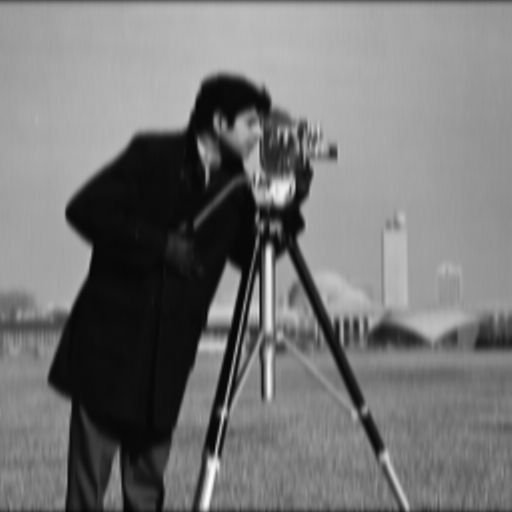

In [222]:
Gray.(Ac*Xtrue)

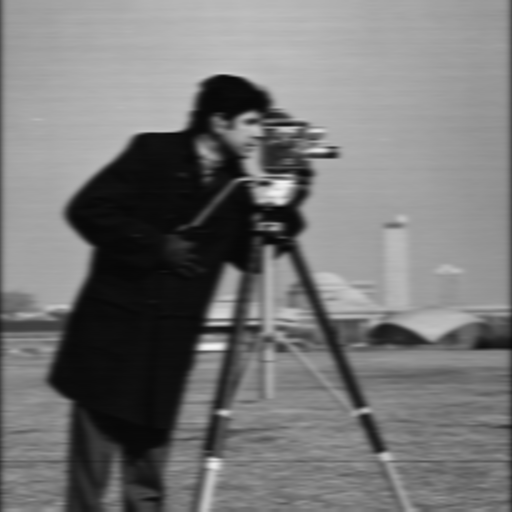

In [223]:
Gray.(Xtrue*Ar')

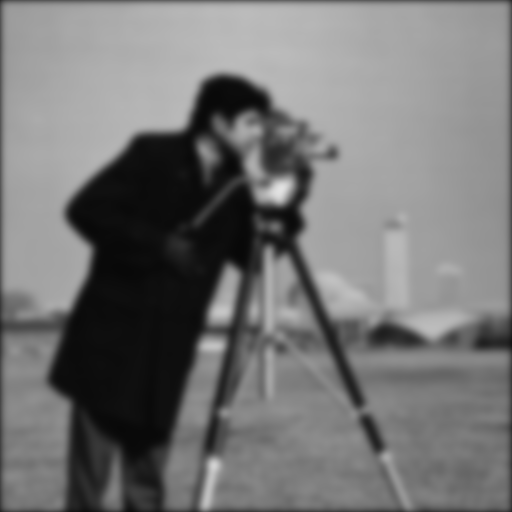

In [224]:
Gray.(Ac*Xtrue*Ar')

### What we observed:

>When we mulitplied the Ac matrix with Xtrue, it blurred the picture vertically. 
>>When we mulitplied the Ar' matrix with Xtrue, it blurred the picture horizantally.
>>>Then when we mutplied the all three matrices, it blurred the picture.

In [225]:
m = size(img,1)
n = size(img,2)
function blur(X, Ac, Ar, τ) 
    Y = Ac*X*Ar' + τ*randn(m,n)
    for x = 1:size(Y,1), y=1:size(Y,2)
        Y[x,y] = clamp01(Y[x,y])
    end
    return Y 
end

blur (generic function with 1 method)

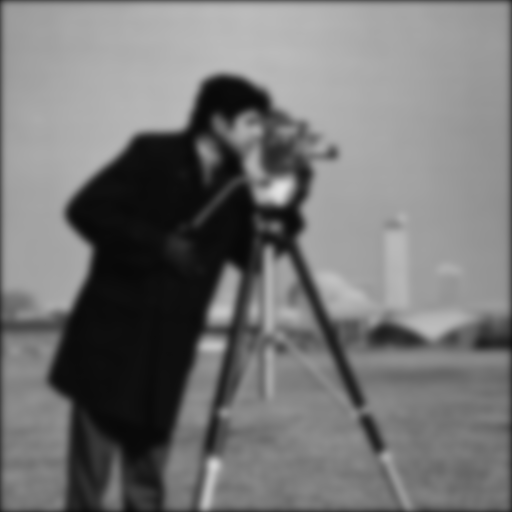

In [226]:
Gray.(blur(Xtrue, Ac, Ar, 1e-4))

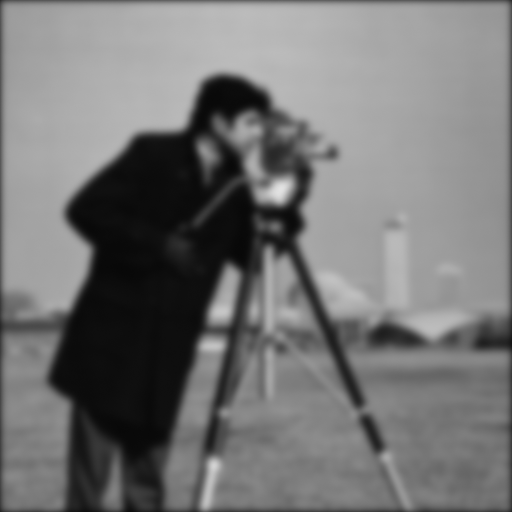

In [227]:
Gray.(blur(Xtrue, Ac, Ar, 1e-3))

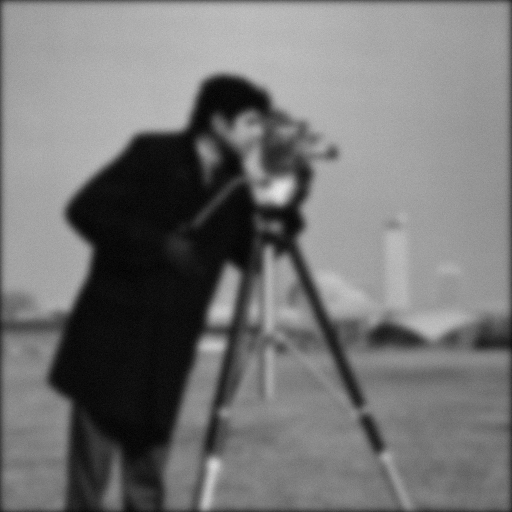

In [228]:
Gray.(blur(Xtrue, Ac, Ar, 1e-2))

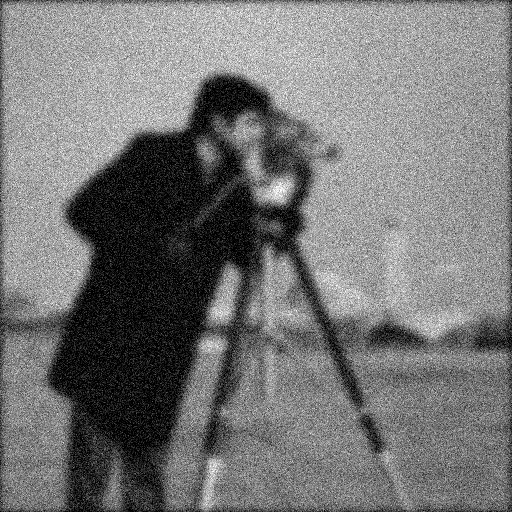

In [229]:
Gray.(blur(Xtrue, Ac, Ar, 1e-1))

### Answer for 3):
>For when $\tau$ is `1e-1`, the noise is most visible.

---

## A simple deblurring approach

In the noiseless case, we have $Y = A_c X A_r^T$, which implies that 

$$X = A_c^{-1} Y A_r^{-T}.$$ 

---
### Exercise 4

1. Write a function `deblur(Y, Ac, Ar)` that implements the above simple approach to deblur an image $Y$. Do not use the `inv` function; use the `\` and `/` functions instead. Use `clamp01` to ensure that $0 \le x_{ij} \le 1$. 

2. Experiment with your function on both noisy and noiseless blurred images $Y$. Experiment with different amounts of blurring and noise. For which values of $\sigma$ and $\tau$ does this method produce good results?

In [230]:
using LinearAlgebra
function deblur(Y, Ac, Ar)
    AcI = Matrix{Float64}(I, size(Ac,1), size(Ac,1))
    ArI = Matrix{Float64}(I, size(Ar,1), size(Ar,1))

    X = (Ac\AcI)*Y*(Ar\ArI)' 

    for x = 1:size(X,1), y=1:size(X,2)
        X[x,y] = clamp01(X[x,y])
    end
    return X
end

deblur (generic function with 1 method)

In [231]:
n = size(Xtrue,1)

Acσ2 = Arσ2 = blurmatrix(n, 2)
Acσ4 = Arσ4 = blurmatrix(n, 4)
Acσ10 = Arσ10 = blurmatrix(n, 10)
Acσ15 = Arσ15 = blurmatrix(n, 15)


noiselessY1 = blur(Xtrue, Acσ2, Arσ2, 1e-4)
noiselessY2 = blur(Xtrue, Acσ4, Arσ4, 1e-4)
noiselessY3 = blur(Xtrue, Acσ10, Arσ10, 1e-4)
noiselessY4 = blur(Xtrue, Acσ15, Arσ15, 1e-4)


noisyY1 = blur(Xtrue, Acσ2, Arσ2, 1e-1)
noisyY2 = blur(Xtrue, Acσ4, Arσ4, 1e-1)
noisyY3 = blur(Xtrue, Acσ10, Arσ10, 1e-1)
noisyY4 = blur(Xtrue, Acσ15, Arσ15, 1e-1)

#Testing different low noise and low blur
lowNoiseLowBlur = blur(Xtrue, Acσ2, Arσ2, 1e-50)

#Testing different low noise and high blur
lowNoiseHighBlur = blur(Xtrue, Acσ15, Arσ15, 1e-50)

#Testing different high noise and low blur
highNoiseLowBlur = blur(Xtrue, Acσ2, Arσ2, 1e-1)

#Testing different high noise and high blur
highNoiseHighBlur = blur(Xtrue, Acσ15, Arσ15, 1e-1);

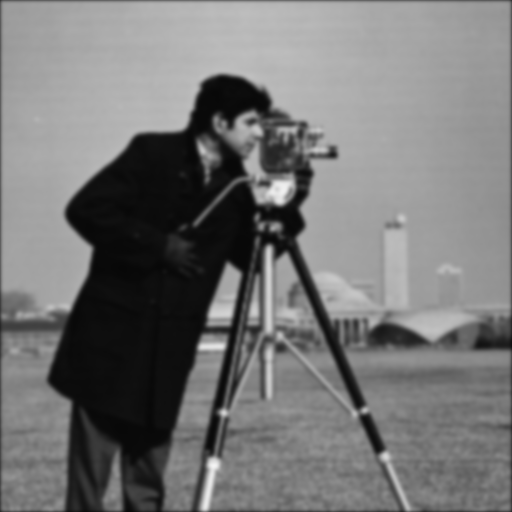

In [232]:
Gray.(noiselessY1)

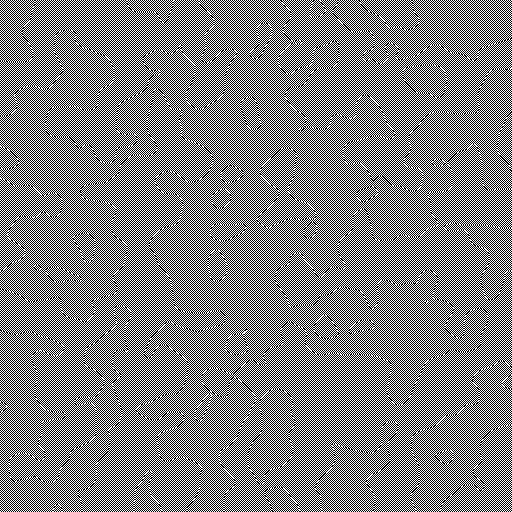

In [233]:
Gray.(deblur(noiselessY1,Acσ2, Arσ2))

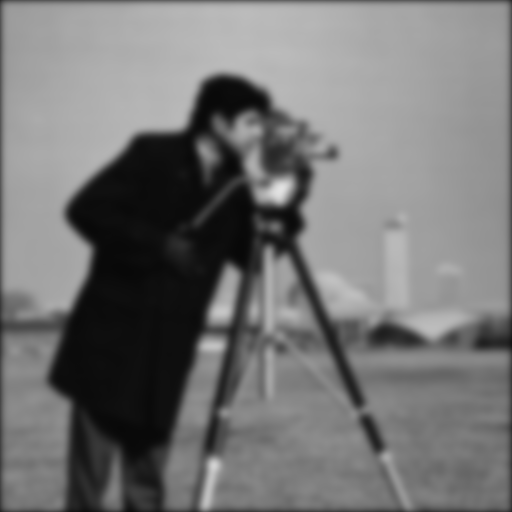

In [234]:
Gray.(noiselessY2)

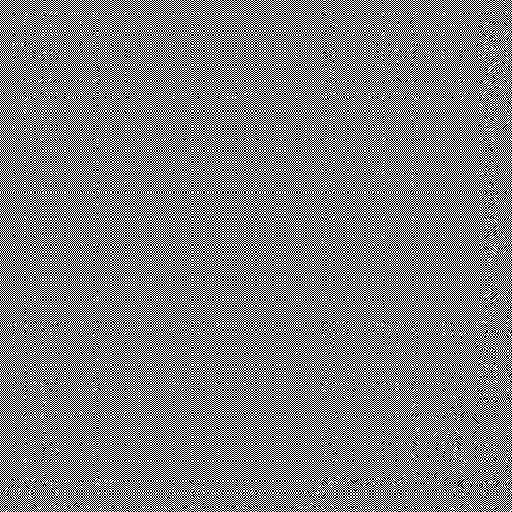

In [235]:
Gray.(deblur(noiselessY2,Acσ4, Arσ4))

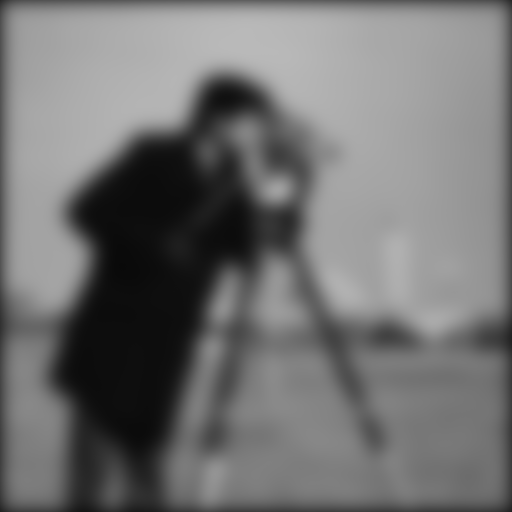

In [236]:
Gray.(noiselessY3)

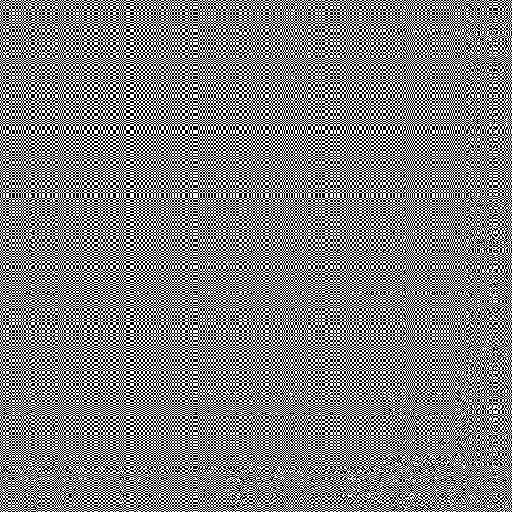

In [237]:
Gray.(deblur(noiselessY3,Acσ10, Arσ10))

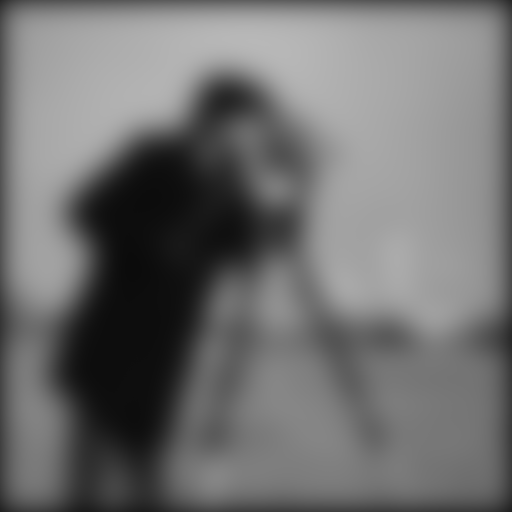

In [238]:
Gray.(noiselessY4)

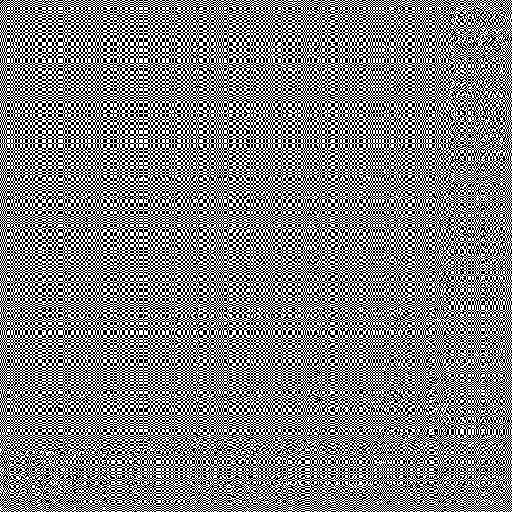

In [239]:
Gray.(deblur(noiselessY4,Acσ15, Arσ15))

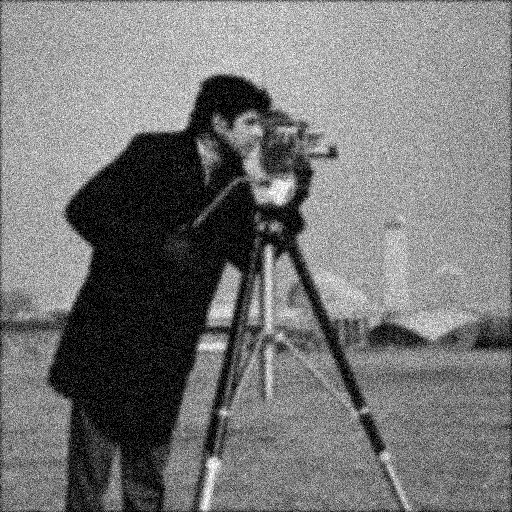

In [240]:
Gray.(noisyY1)

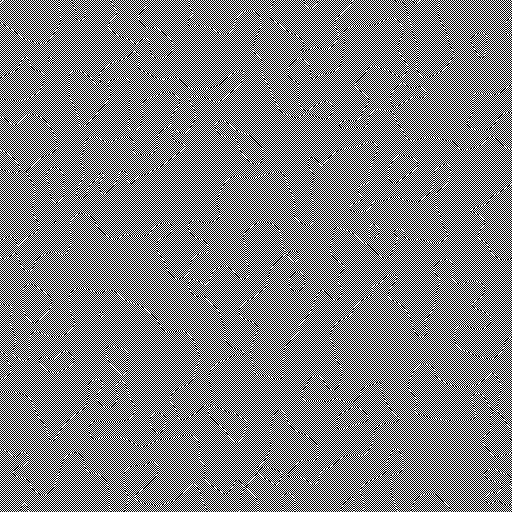

In [241]:
Gray.(deblur(noisyY1,Acσ2, Arσ2))

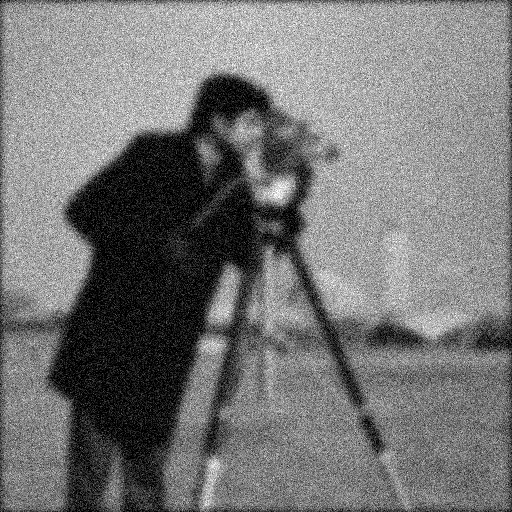

In [242]:
Gray.(noisyY2)

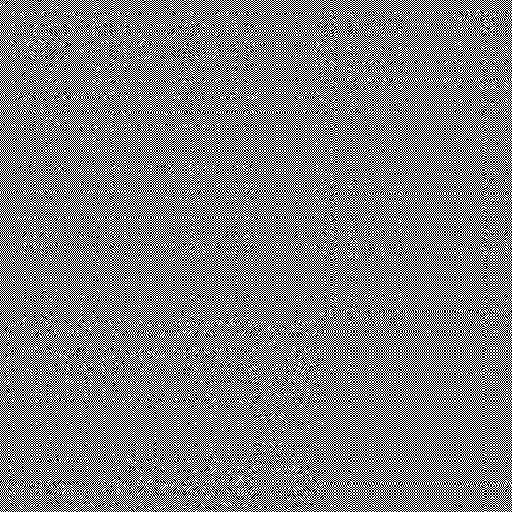

In [243]:
Gray.(deblur(noisyY2,Acσ4, Arσ4))

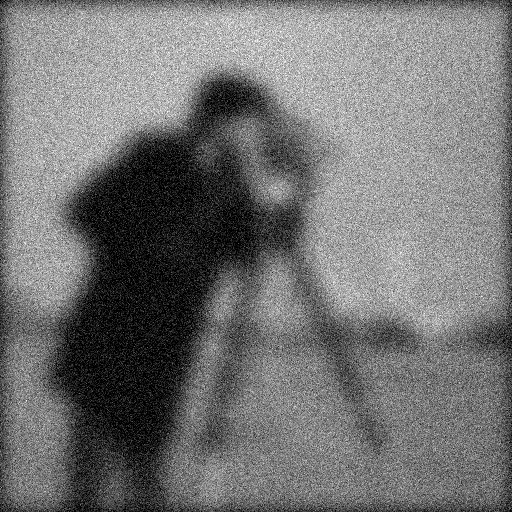

In [244]:
Gray.(noisyY3)

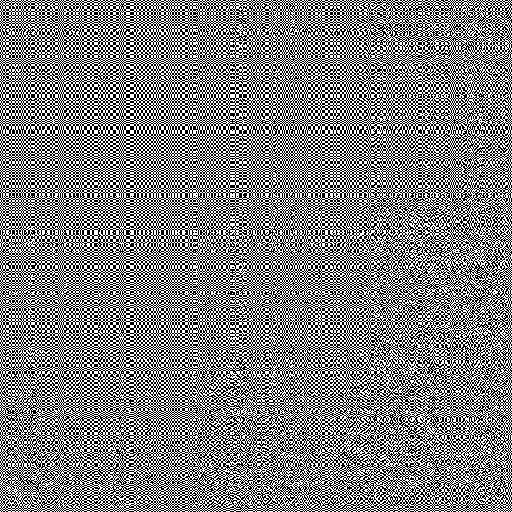

In [245]:
Gray.(deblur(noisyY3,Acσ10, Arσ10))

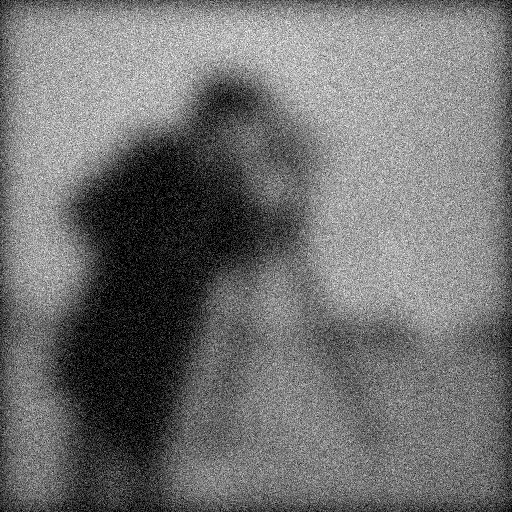

In [246]:
Gray.(noisyY4)

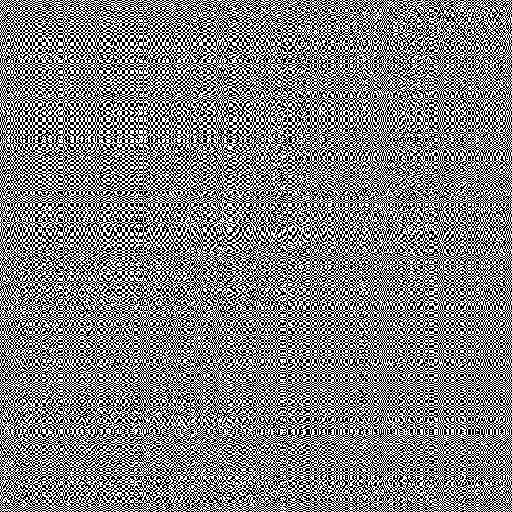

In [247]:
Gray.(deblur(noisyY4,Acσ15, Arσ15))

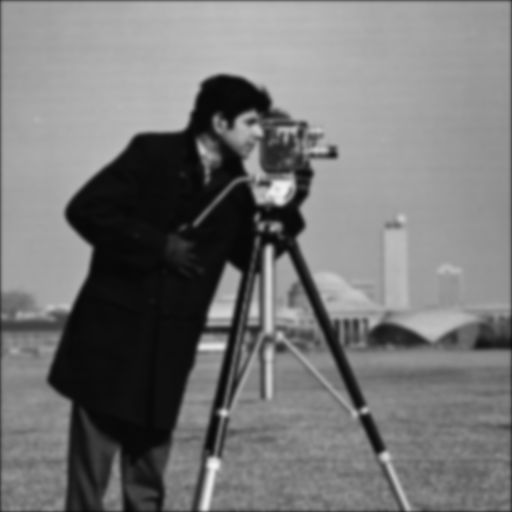

In [248]:
Gray.(lowNoiseLowBlur)

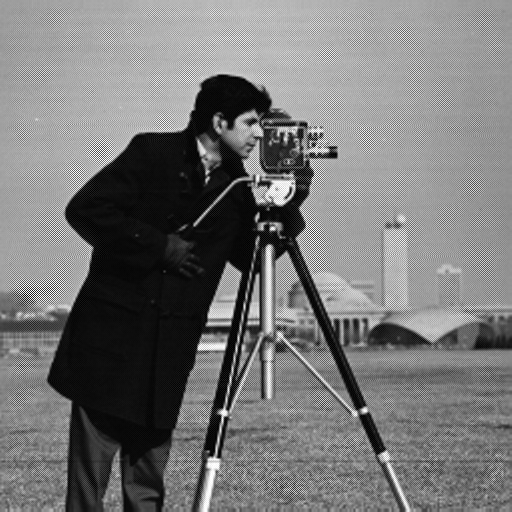

In [249]:
Gray.(deblur(lowNoiseLowBlur,Acσ2, Arσ2))

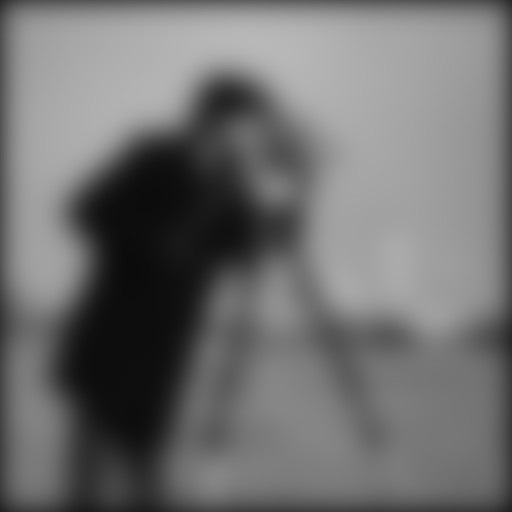

In [250]:
Gray.(lowNoiseHighBlur)

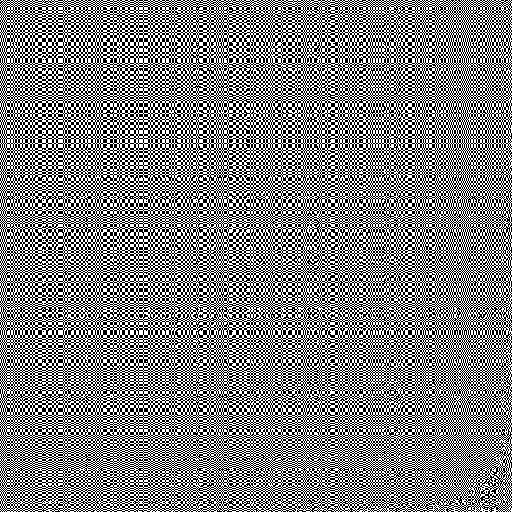

In [251]:
Gray.(deblur(lowNoiseHighBlur,Acσ15, Arσ15))

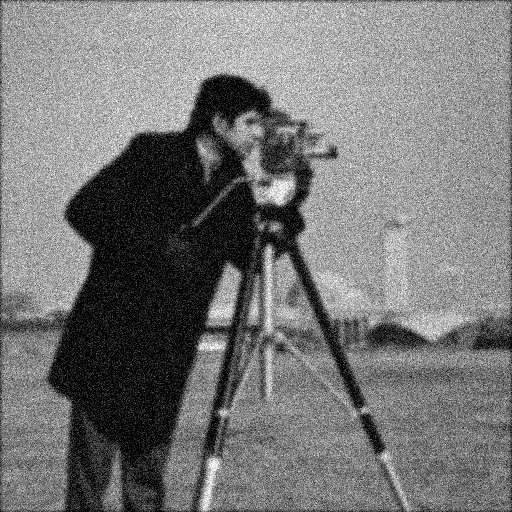

In [252]:
Gray.(highNoiseLowBlur)

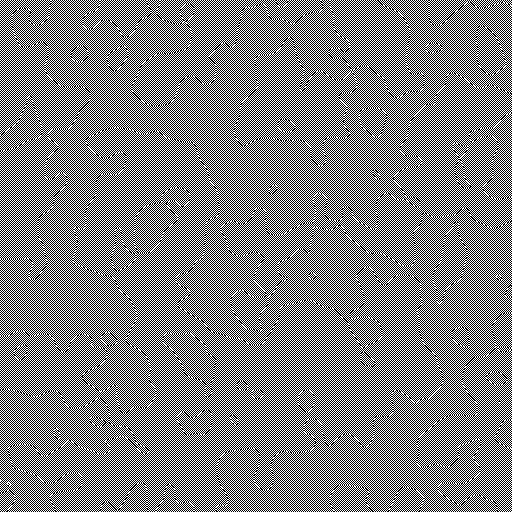

In [253]:
Gray.(deblur(highNoiseLowBlur,Acσ2, Arσ2))

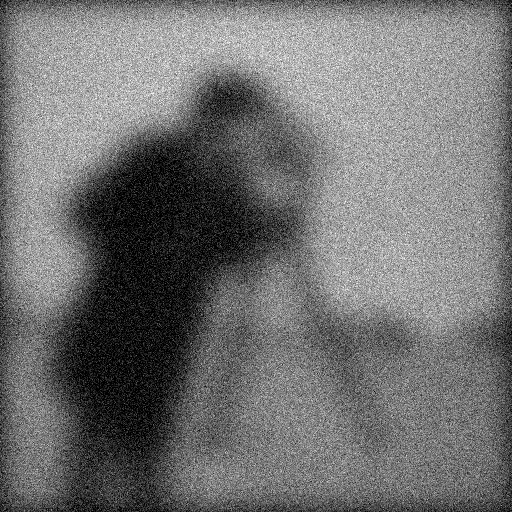

In [254]:
Gray.(highNoiseHighBlur)

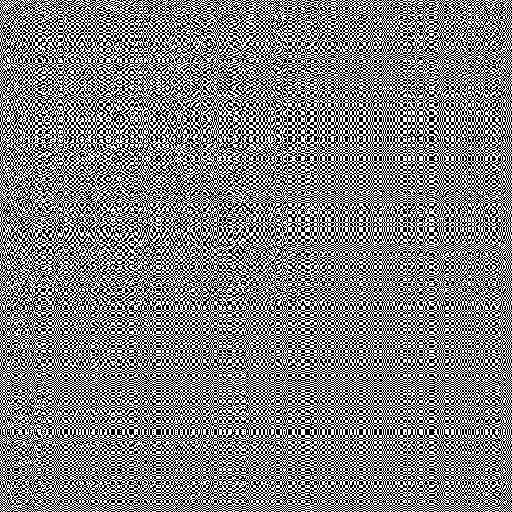

In [255]:
Gray.(deblur(highNoiseHighBlur,Acσ15, Arσ15))

## Answer for part 2)

>When $\sigma$ is `2` and $\tau$ is `1e-50`, it produced the best result. In conclusion, we noticed with a low blur and low noise, it does not mess with the original photo too much and was able to be deblurred without much distortion. As we increased the noise, the deblur function did not excecute as well as we hoped. Same for the increase of the blur, again, it did not get the result we wanted.

---

## Tikhonov regularization

The simple approach we explored in Exercise 3 is very sensitive to noise and blurring. [Tikhonov regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization) can be an effective way to perform image debluring that is less sensitive. Instead of solving $A_cXA_r^T = Y$ for the matrix $X$, we seek $X$ that minimizes

$$
\left\|A_c X A_r^T - Y\right\|_F^2 + \alpha \left\|X\right\|_F^2,
$$

for some $\alpha \ge 0$. Recall that $$\|A\|_F = \sqrt{\sum_{i=1}^m \sum_{j=1}^n a_{ij}^2}$$ is the Frobenius norm of a matrix $A \in \mathbb{R}^{m \times n}$. Setting $\alpha = 0$ gives us our previous simple approach. Larger $\alpha$ means that $X$ should not have entries that are too large; this makes sense since we require $0 \leq x_{ij} \leq 1$.

We can find the $X$ that gives us the minimum value of $\left\|A_c X A_r^T - Y\right\|_F^2 + \alpha \left\|X\right\|_F^2$ using the **singular value decomposition**.

---

## The Singular Value Decompositon (SVD)

For a full treatment of the singular value decomposition, see Chapter 4 in _Fundamentals of Matrix Computations_ by Watkins. For this case study, we only need to know the following theorem.

> ### Theorem: (SVD Theorem)
>
> Let $A \in \mathbb{R}^{m \times n}$ be a nonzero matrix with rank $r$. Then $A$ can be expressed as a product
>
> $$A = U \Sigma V^T,$$
>
> where $U \in \mathbb{R}^{m \times m}$ and $V \in \mathbb{R}^{n \times n}$ are orthogonal, and $\Sigma \in \mathbb{R}^{m \times n}$ is a rectangular "diagonal" matrix
>
> $$
  \Sigma = 
  \begin{bmatrix}
  \sigma_1 \\
  & \sigma_2 \\
  && \ddots \\
  &&& \sigma_r \\
  &&&& 0 \\
  &&&&& \ddots
  \end{bmatrix}
  \qquad
  \sigma_1 \ge \sigma_2 \ge \cdots \ge \sigma_r > 0.
  $$
  
The entries $\sigma_1, \ldots, \sigma_r$ of $\Sigma$ are called the **singular values** of $A$.

---
### Exercise 5

1. Read the documentation on the `Julia` function `svd` and use it to compute the SVD of the matrix
   
   $$
   A = 
   \left[
   \begin{array}{rrr}
   -2 & -5 & 4 \\
   2 & -7 & 4 \\
   1 & 4 & -3 \\
   \end{array}
   \right].
   $$
   
   Verify that $A = U \Sigma V^T$. Looking at the singular values, what is the rank of $A$?
   
2. Recall that a matrix $U$ is **orthogonal** if it is square and $U^TU = UU^T = I$. Verify that the matrices $U$ and $V$ computed in part 1 are orthogonal.

In [256]:
#   ***PART 1***

using LinearAlgebra

A = [-2 -5 4 ; 2 -7 4 ; 1 4 -3]



U = svd(A).U

3×3 Array{Float64,2}:
 -0.561311   0.638085  0.527046
 -0.701857  -0.704476  0.105409
  0.438551  -0.310744  0.843274

In [257]:
S = Diagonal(svd(A).S)

3×3 Diagonal{Float64,Array{Float64,1}}:
 11.4163   ⋅        ⋅         
   ⋅      3.10927   ⋅         
   ⋅       ⋅       2.37376e-16

In [258]:
V = svd(A).V

3×3 Adjoint{Float64,Array{Float64,2}}:
  0.0137925  -0.963525  -0.267261
  0.829843    0.160144  -0.534522
 -0.557826    0.214412  -0.801784

In [259]:
Vt = svd(A).Vt

3×3 Array{Float64,2}:
  0.0137925   0.829843  -0.557826
 -0.963525    0.160144   0.214412
 -0.267261   -0.534522  -0.801784

In [260]:
M = U*S*Vt

3×3 Array{Float64,2}:
 -2.0  -5.0   4.0
  2.0  -7.0   4.0
  1.0   4.0  -3.0

In [261]:
rank(A)

2

In [262]:
#   ***PART 2***

U * U' # Returns Identity if Orthogonal

3×3 Array{Float64,2}:
  1.0           2.84495e-16  -1.66533e-16
  2.84495e-16   1.0          -9.71445e-17
 -1.66533e-16  -9.71445e-17   1.0        

In [263]:
V * V' # Returns Identity if Orthogonal

3×3 Array{Float64,2}:
  1.0          5.55112e-17  -5.55112e-17
  5.55112e-17  1.0           2.22045e-16
 -5.55112e-17  2.22045e-16   1.0        

---
### Exercise 6

1. An important property about orthogonal matrices is that multiplication by them does not change the Euclidean length of vectors; that is, if $U \in \mathbb{R}^{n \times n}$ is orthogonal, then $\|Ux\|_2 = \|x\|_2$, for all vectors $x \in \mathbb{R}^n$. Prove this by using the formula $\|x\|_2^2 = x^Tx$.

2. Let $M \in \mathbb{R}^{m \times n}$. Prove that if $U \in \mathbb{R}^{m \times m}$ and $V \in \mathbb{R}^{n \times n}$ are orthogonal, then $\|UM\|_F = \|M\|_F$ and $\|MV\|_F = \|M\|_F$.

1)

Given the formula, $\|x\|_2^2 = x^Tx$ we must prove that $\|x\|_2^2 = \|Ux\|_2^2$ thus showing $\|Ux\|_2 = \|x\|_2$

$\|\hat{x}\|_2^2 = x^Tx$, setting $\hat{x} = Ux$ we get...

$$
\|Ux\|_2^2 = (Ux)^{T}Ux = x^{T}U^{T}Ux
$$

Because $U$ is orthoganal, we know that $U^{T}U = I$, thus...

$$
\|Ux\|_2^2 = x^{T}U^{T}Ux = x^{T}Ix = x^Tx
$$

So...

$$
\|Ux\|_2 = \|x\|_2
$$

2)

We know that for any Orthogonal square Matrix $O$ we know that $O^TO = OO^T = I$

$$
\|\hat{M}\|_F = \sqrt{\sum_{i}\sum_{j}|\hat{M}|^2}
$$
$$
\|\hat{M}\|_F^2 = \sum_{ij} \hat{M}^T_{ij}\hat{M}_{ji} =  \sum_{ij} \hat{M}_{ij}\hat{M}^T_{ji}
$$

---

If we substitute $\hat{M}$ with $UM$ into $\|\hat{M}\|_F^2 = \sum_{ij} \hat{M}^T_{ij}\hat{M}_{ji}$ we get...

$$
\|UM\|_F^2 = \sum_{ij} (UM)^TUM
$$
$$
\|UM\|_F^2 = \sum_{ij} M^TU^TUM = \sum_{ij} M^T I M = \sum_{ij} M^TM = \|M\|_F^2
$$

---

Similarly for $MU$ substituted into $\|\hat{M}\|_F^2 = \sum_{ij} \hat{M}_{ij}\hat{M}^T_{ji}$ we get ...
$$
\|MU\|_F^2 = \sum_{ij} MU(MU)^T
$$
$$
\|MU\|_F^2 = \sum_{ij} MUU^TM^T = \sum_{ij} M I M^T = \sum_{ij} MMT = \|M\|_F^2
$$

---

Thus because $\|UM\|_F^2 = \|MU\|_F^2 = \|M\|_F^2$, we know $\|UM\|_F = \|MU\|_F = \|M\|_F$

---
### Exercise 7

1. Let $A_c = U_c S_c V_c^T$ and $A_r = U_r S_r V_r^T$ be the singular value decompositions of the blurring matrices $A_c$ and $A_r$, respectively. Prove that
   
   $$
   \left\|A_c X A_r^T - Y\right\|_F^2 + \alpha \left\|X\right\|_F^2 = 
   \left\|S_c \bar{X} S_r - \bar{Y}\right\|_F^2 + \alpha \left\|\bar{X}\right\|_F^2,
   $$
   
   where $\bar{X} = V_c^T X V_r$ and $\bar{Y} = U_c^T Y U_r$.
   
2. Let $s_{ij} = \sigma_i(A_c)\sigma_j(A_r)$, where $\sigma_i(A_c)$ is the $i$th singular value of $A_c$ and $\sigma_j(A_r)$ is the $j$th singular value of $A_r$. Prove that
   
   $$
   \left\|S_c \bar{X} S_r - \bar{Y}\right\|_F^2 + \alpha \left\|\bar{X}\right\|_F^2 = 
   \sum_{ij} \left( \left(s_{ij}^2 + \alpha\right) \bar{x}_{ij}^2 - 2s_{ij}\bar{x}_{ij}\bar{y}_{ij} + \bar{y}_{ij}^2\right),
   $$
   
   where $\bar{x}_{ij}$ and $\bar{y}_{ij}$ are the $(i,j)$ entries of the matrices $\bar{X}$ and $\bar{Y}$, respectively.
   
3. The sum in part 2 can be minimized by finding $\bar{x}_{ij}$ that minimizes $\left(s_{ij}^2 + \alpha\right) \bar{x}_{ij}^2 - 2s_{ij}\bar{x}_{ij}\bar{y}_{ij} + \bar{y}_{ij}^2$. To this end, consider the function
   
   $$
   f(x) = (s^2 + \alpha)x^2 - 2syx + y^2,
   $$
   
   where $\alpha > 0$ and $s, y \in \mathbb{R}$ are considered as constants. Determine the $x$ that minimizes $f(x)$ by solving $f'(x) = 0$ and checking that $f''(x) > 0$. Then give the formula for the optimal $\bar{x}_{ij}$.
   
4. Prove that $X = V_c \bar{X} V_r^T$.


---
1)

Given $\bar{X} = V_c^TXV_r$ and $\bar{Y} = U_c^TYU_r$

To prove: $\left\|A_c X A_r^T - Y\right\|_F^2 + \alpha \left\|X\right\|_F^2 = 
   \left\|S_c \bar{X} S_r - \bar{Y}\right\|_F^2 + \alpha \left\|\bar{X}\right\|_F^2$
   
We seek to prove seperately, 

1. $\|A_cXA_r^T - Y\|_F^2 = \|S_c\bar{X}S_r - \bar{Y}\|_F^2$
2. $\alpha\|X\|_F^2 = \alpha\|\bar{X}\|_F^2$

---

To Prove: $\|A_cXA_r^T - Y\|_F^2 = \|S_c\bar{X}S_r - \bar{Y}\|_F^2$ 
--

(You could do it another way with the equation found in the end...)



Starting from the right side,

We can substitute our equations for $\bar{X}$ and $\bar{Y}$ to produce...


$\|S_cV_c^TXV_rS_r - U_c^TYU_r\|_F^2$


We know from Excersice 6.2 that $\|UM\|_F^2 = \|MU\|_F^2 = \|M\|_F^2$ For any Orthogonal Square Matrix U

We can left and then right multiply our orthoginal matricies $U_c$ and $U_r^T$ inside our F-Norm ($U_cU_c^T$ and $U_rU_r^T$ eliminate to the identity mtx) 

giving us... 


$\|A_cXA_r^T - Y\|_F^2 = \|U_cS_cV_c^TXV_rS_rU_r^T - Y\|_F^2$

Using, $A_c = U_c S_c V_c^T$ and $A_r = U_r S_r V_r^T$

We substitute $U_cS_cV_c^T$ for $A_c$

$A_r^T$ is found to be $V_rS_r^TU_r^T$. 

$S_r$ being a diagonal Matrix, we know that $S_r = S_r^T$,

thus, 

$A_r^T = V_rS_rU_r^T$

Substituting $A_r^T$ to the right of $X$ gives us...$ \|A_cXA_r^T - Y\|_F^2$
--

---

To Prove: $\alpha\|X\|_F^2 = \alpha\|\bar{X}\|_F^2$  
--

We must first substitute  $V_c^TXV_r$ for $\bar{X}$ giving us...

$$
\alpha\|X\|_F^2 = \alpha\|V_c^TXV_r\|_F^2
$$

Again, without changing the F-norm value of the right side, we are allowed to left, and then right multiply the inside equation by the Orthoginal Matricies $V_c$ and $V_r^T$ 

We are left with...

$$
\alpha\|X\|_F^2 = \alpha\|V_cV_c^TXV_rV_r^T\|_F^2 = \alpha\|IXI\|_F^2 = \alpha\|X\|_F^2 = \alpha\|\bar{X}\|_F^2
$$

thus

$\alpha\|X\|_F^2 = \alpha\|\bar{X}\|_F^2$
---
---

Now that we know that each corresponding F-Norm on the right and left of the equation is Equal,

The sum of the coresponding parts are also Equal, 

thus...

$$
\left\|A_c X A_r^T - Y\right\|_F^2 + \alpha \left\|X\right\|_F^2 = \left\|S_c \bar{X} S_r - \bar{Y}\right\|_F^2 + \alpha \left\|\bar{X}\right\|_F^2
$$
---

---

2)

Given: $\sum_{ij} \left( \left(s_{ij}^2 + \alpha\right) \bar{x}_{ij}^2 - 2s_{ij}\bar{x}_{ij}\bar{y}_{ij} + \bar{y}_{ij}^2\right)$

We can decompose and factor this equation into one that looks similar to the left side of the equation,

$$
\left\|S_c \bar{X} S_r - \bar{Y}\right\|_F^2 + \alpha \left\|\bar{X}\right\|_F^2 = \sum_{ij} (s_{ij}\bar{x}_{ij}^2 - 2s_{ij}\bar{x}_{ij}\bar{y}_{ij} + \bar{y}_{ij}^2 + \alpha\bar{x}_{ij}^2
$$

$$
\left\|S_c \bar{X} S_r - \bar{Y}\right\|_F^2 + \alpha \left\|\bar{X}\right\|_F^2 = \sum_{ij} ((s_{ij}\bar{x}_{ij} - {y}_{ij})^2 + \alpha\bar{x}_{ij}^2)
$$

in this equation...

1. The $\sum_{ij} (...)^2$  mirrors both $\|*\|_F^2$

    The F-norm involves summing up the squares of all elements of the array and taking the root of the result.
    The F-norm$^2$ will loose the outer root.

2. $s_{ij}\bar{x}_{ij}$ represents $S_c\bar{X}S_r$

    $s_{ij}$ represents the $i$th singular value of $A_c$ multiplied by the $j$th singular value of $A_r$. 
    $S_c\bar{X}$ scales every element row of $\bar{X}$ by the the singular value for $A_c$ in $S_c$ for that row.
    $(S_c\bar{X})S_r$ takes the matrix we found and scales the columns by the singular values for $A_r$ in $S_r$
    
   Thus, every element in the $\bar{X}$ array is scaled by $\sigma_i(A_c)\sigma_j(A_r) = s_{ij}$

3. $y_{ij}$ represents $\bar{Y}$

    Every item in $S_c\bar{X}S_r$ will be subtracted by the corresponding element in $\bar{Y}$

4. $\alpha\bar{x}_{ij}^2$ corresponds to $\alpha\|\bar{X}\|_F^2$


Together this shows how $\left\|S_c \bar{X} S_r - \bar{Y}\right\|_F^2 + \alpha \left\|\bar{X}\right\|_F^2 = \sum_{ij} ((s_{ij}\bar{x}_{ij} - {y}_{ij})^2 + \alpha\bar{x}_{ij}^2) = \sum_{ij} \left( \left(s_{ij}^2 + \alpha\right) \bar{x}_{ij}^2 - 2s_{ij}\bar{x}_{ij}\bar{y}_{ij} + \bar{y}_{ij}^2\right)$

---
3)

When finding an optimal $x$ for $f(x) = (s^2 + \alpha) x^2 - 2 s y x + y^2$

We find that $f'(x) = 2(s^2 + \alpha)x - 2sy = 0$

Lastly we also find that $f''(x) = 2(s^2 + \alpha) \ge 0$ (Given: $\alpha \gt 0$)

Finding the optimal $x$, we look for $x$ when $f'(x) = 0$

$0 = 2(s^2 + \alpha)x - 2sy$

thus

we arrive at our formula for the optimal x value being,

$\frac{2sy}{2(s^2 + \alpha)} = x$




---

4)


Given $\bar{X} = V_c^TXV_r$, we can left multiply and right multiply the orthoganal Transposes of $V_c^T$ and $V_r$, we get

$$
V_c\bar{X}V_r^T = V_cV_c^TXV_rV_r^T
$$

using laws of orthoginal matricies: $V_cV_c^T = I$ and $V_rV_r^T = I$

thus...

$$
X = V_c\bar{X}V_r^T
$$

---
### Exercise 8

1. Write a function `tikdeblur(Y, Ac, Ar; α=1e-4)` that implements the approach outlined in Exercise 7 to deblur an image $Y$. Use `clamp01` to ensure that $0 \le x_{ij} \le 1$. 

2. Experiment with your function on both noisy and noiseless blurred images $Y$. Experiment with different amounts of blurring and noise. For which values of $\sigma$ and $\tau$ does this method produce good results? Use your function with `α = 1e-6, ..., 1e-1` and `α = 0.0`. Is `α = 1e-4` a good default value, or would you recommend a different default value for $\alpha$?

In [264]:
function tikdeblur(Y, Ac, Ar; α=1e-4)
    S = zeros(size(Ac,1),size(Ar,1))
    Sc = svd(Ac).S
    Sr = svd(Ar).S
    Vc = svd(Ac).Vt
    Vr = svd(Ar).Vt
    Uc = svd(Ac).U
    Ur = svd(Ar).U
    X = zeros(size(Y,1),size(Y,2))
    Xbar = zeros(size(Y,1),size(Y,2))
    Ybar = zeros(size(Y,1),size(Y,2))
    Ybar = Uc'Y*Ur
    
    for j = 1:size(Sc,1)
        for i = 1:size(Sr,1)
            S[i,j] = Sc[i] * Sr[j]
        end
    end
    
    for i = 1:size(Ybar,1)
        for j = 1:size(Ybar,2)
            Xbar[i, j] = (S[i,j]*Ybar[i,j])/((S[i,j])^2+α)
        end
    end
    X = Vc'Xbar*Vr
    for x = 1:size(X,1), y=1:size(X,2)
        X[x,y] = clamp01(X[x,y])
    end
    return X
end

tikdeblur (generic function with 1 method)

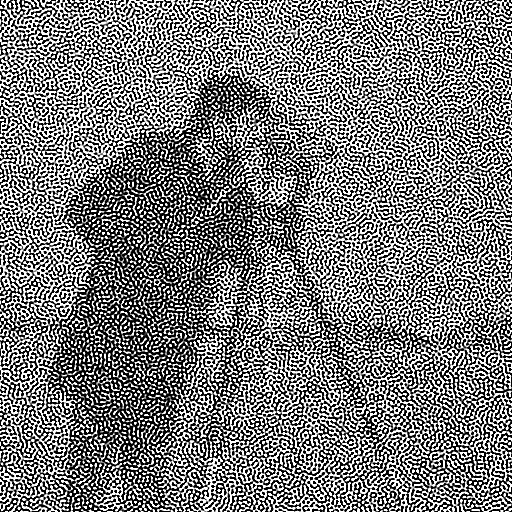

In [272]:
Gray.(tikdeblur(highNoiseLowBlur,Acσ2, Arσ2))

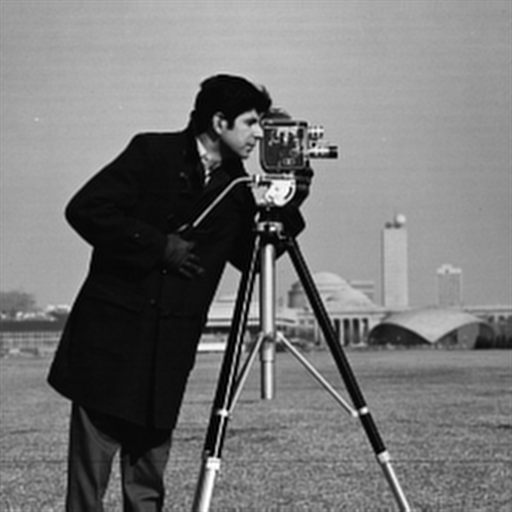

In [266]:
Gray.(tikdeblur(lowNoiseLowBlur,Acσ2, Arσ2))

---
### Exercise 9

Use your `tikdeblur` function to read the sign in the image `blurrysign.tif`.

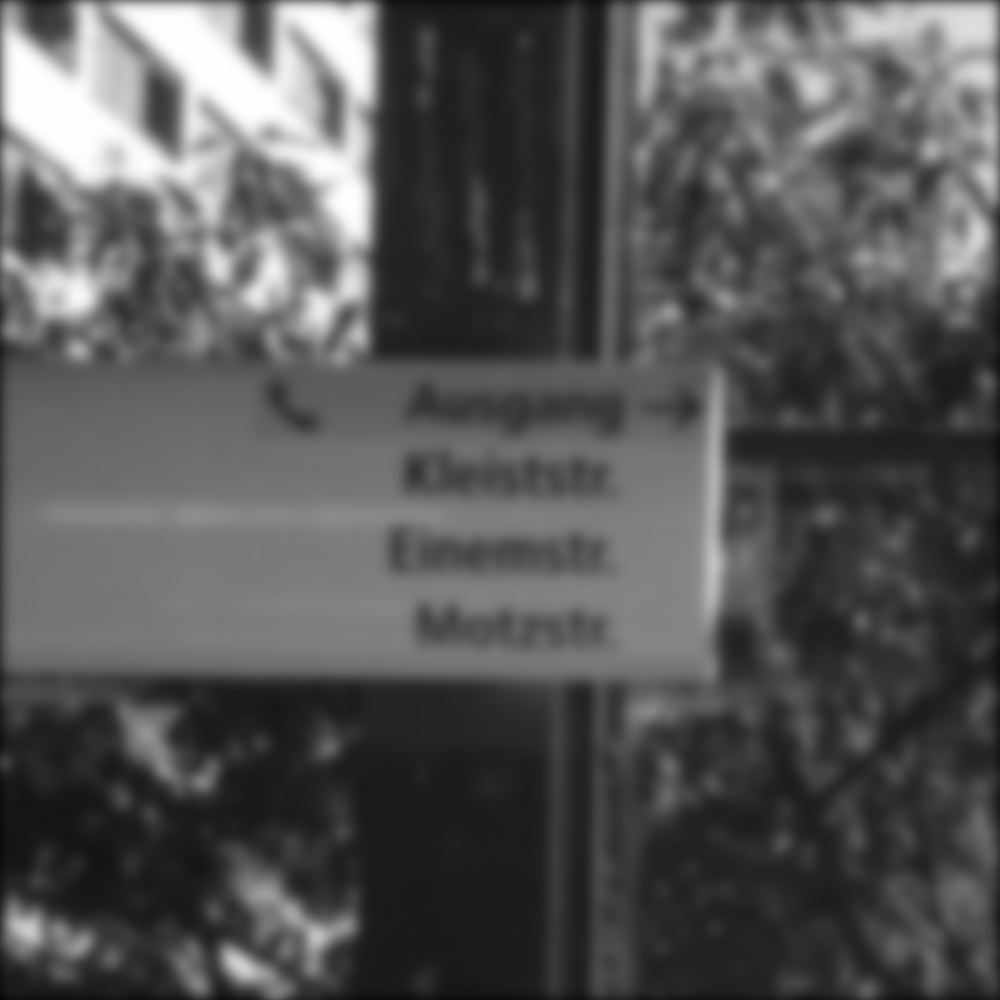

In [267]:
img2 = load("blurrysign.tif")

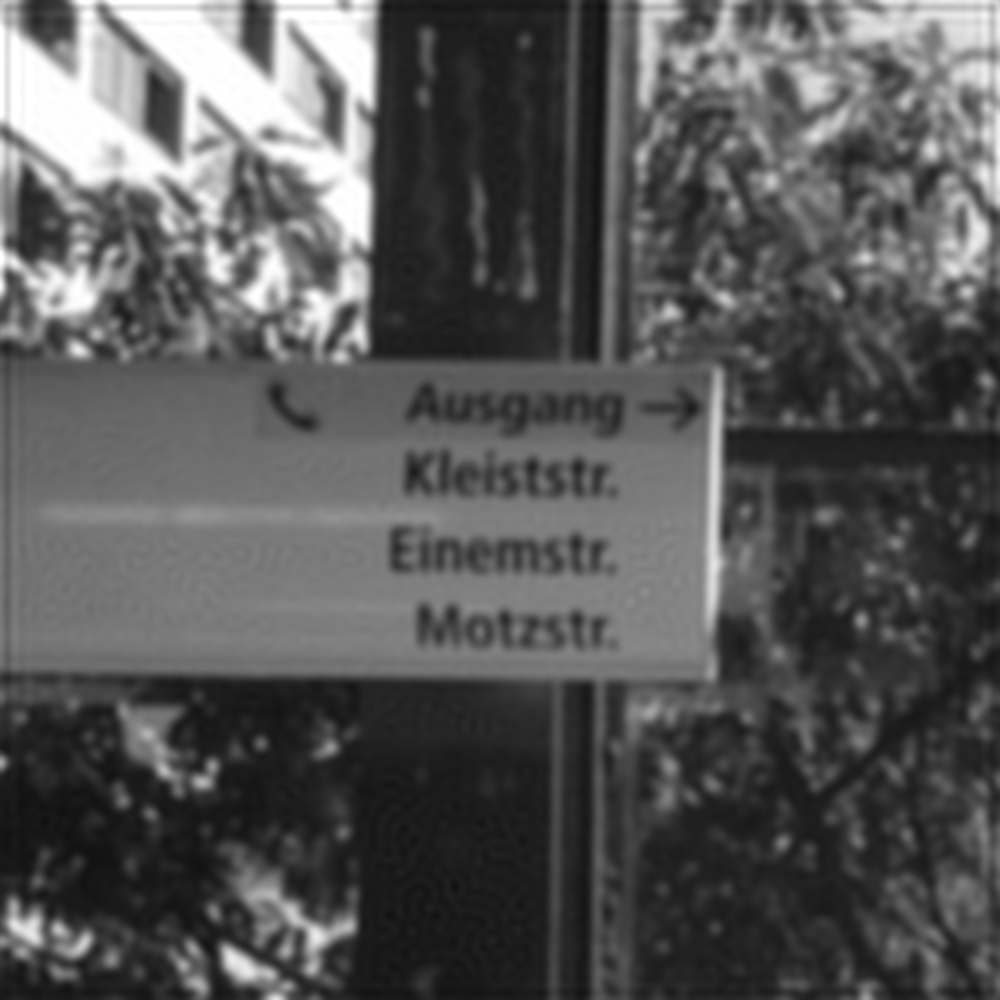

In [268]:
n = size(img2,1)
m = size(img2,2)
z  = 6
blurmatrix2(n, m, σ) = [f(x, μ=y, σ=σ) for x=1:n, y=1:m]
Ac = blurmatrix2(n,m,z)
Ar = blurmatrix2(n,m,z)
Gray.(tikdeblur(img2, Ac, Ar; α=1e-3))

---